<a href="https://colab.research.google.com/github/imvishal09/Netflix_Stock_Price_Trend_Prediction/blob/main/Netflix_Stock_Price_Trend_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset source: https://www.kaggle.com/akpmpr/updated-netflix-stock-price-all-time

# Import libraries 

In [57]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Upload the csv file from local drive

In [58]:
from google.colab import files
data_load = files.upload()

Saving netflix.csv to netflix (1).csv


# Load the csv file

In [59]:
import io
df = pd.read_csv(io.BytesIO(data_load['netflix.csv']))

# Exploring the Dataset

In [60]:
df.head(df.size)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2002-05-23,1.242857,1.145714,1.156429,1.196429,104790000.0,1.196429
1,2002-05-24,1.225000,1.197143,1.214286,1.210000,11104800.0,1.210000
2,2002-05-28,1.232143,1.157143,1.213571,1.157143,6609400.0,1.157143
3,2002-05-29,1.164286,1.085714,1.164286,1.103571,6757800.0,1.103571
4,2002-05-30,1.107857,1.071429,1.107857,1.071429,10154200.0,1.071429
...,...,...,...,...,...,...,...
4876,2021-10-05,640.390015,606.890015,606.940002,634.809998,9534300.0,634.809998
4877,2021-10-06,639.869995,626.359985,628.179993,639.099976,4580400.0,639.099976
4878,2021-10-07,646.840027,630.450012,642.229980,631.849976,3556900.0,631.849976
4879,2021-10-08,643.799988,630.859985,634.169983,632.659973,3271100.0,632.659973


In [61]:
df.index = df['Date']

In [65]:
df.dtypes

Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

In [66]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,4881.000000,4881.000000,4881.000000,4881.000000,4.881000e+03,4881.000000
mean,107.003361,103.742674,105.388477,105.434149,1.679949e+07,105.434149
std,159.326383,154.662309,157.007060,157.073188,1.936794e+07,157.073188
min,0.410714,0.346429,0.377857,0.372857,2.856000e+05,0.372857
25%,3.977143,3.838571,3.901429,3.906429,6.286300e+06,3.906429
50%,22.261429,21.150000,21.524286,21.632856,1.082310e+07,21.632856
75%,127.430000,123.589996,125.949997,125.389999,2.015640e+07,125.389999
max,646.840027,630.859985,642.229980,639.099976,3.234140e+08,639.099976


we can see 105.4 as the average price closing price and maximum closing price is 639

intiating index as date to plot the price chart

In [67]:
df.index = df['Date']

# Price Chart of Netflix Stock Over The Years

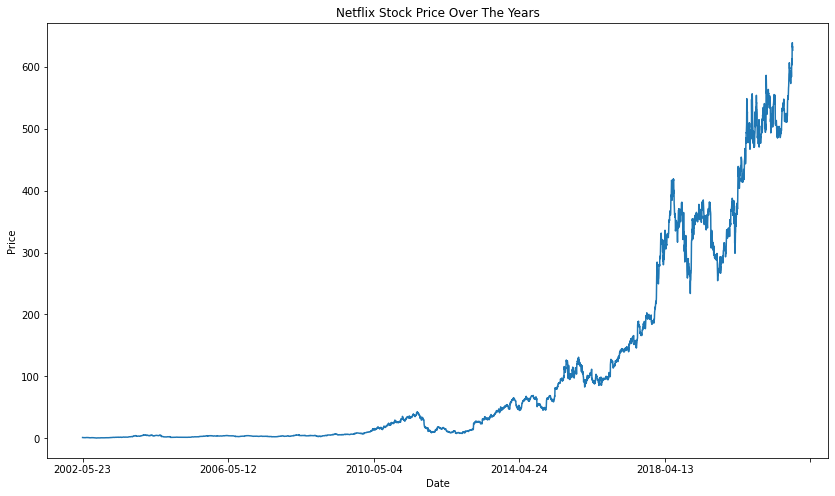

In [68]:
df['Adj Close'].plot(figsize = (14,8))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Netflix Stock Price Over The Years')
plt.show()

# Data Preprocessing

creating a data structure with 90 time steps and 1 output and the output to be close to stock price





In [69]:
length = 90
list1 = []
list2 = []
adj_close = df['Adj Close']

for i in range(len(adj_close) - length):
  x = adj_close[i:i+length]
  y = adj_close[i+length]
  list1.append(x)
  list2.append(y)

convert the lists into numpy arrays and reshape them into 2D arrays

In [70]:
list1 = np.array(list1)
list2 = np.array(list2)
list2 = list2.reshape(-1,1)

list1, list2

(array([[1.19642901e+00, 1.21000004e+00, 1.15714300e+00, ...,
         7.82857001e-01, 7.20000029e-01, 6.92857027e-01],
        [1.21000004e+00, 1.15714300e+00, 1.10357106e+00, ...,
         7.20000029e-01, 6.92857027e-01, 6.78570986e-01],
        [1.15714300e+00, 1.10357106e+00, 1.07142901e+00, ...,
         6.92857027e-01, 6.78570986e-01, 5.78571022e-01],
        ...,
        [4.99079987e+02, 4.99239990e+02, 4.89429993e+02, ...,
         6.03349976e+02, 6.34809998e+02, 6.39099976e+02],
        [4.99239990e+02, 4.89429993e+02, 4.94739990e+02, ...,
         6.34809998e+02, 6.39099976e+02, 6.31849976e+02],
        [4.89429993e+02, 4.94739990e+02, 4.94660004e+02, ...,
         6.39099976e+02, 6.31849976e+02, 6.32659973e+02]]),
 array([[6.78570986e-01],
        [5.78571022e-01],
        [5.17857015e-01],
        ...,
        [6.31849976e+02],
        [6.32659973e+02],
        [6.27039978e+02]]))

taking 4000 as data points to train the model

In [71]:
#train
x_train = list1[:4000]
y_train = list2[:4000]

#test
x_test = list1[4000:]
y_test = list2[4000:]

using MinMaxScaler as object to normalize the values into a range of 0,1 for the model

In [72]:
scaler = MinMaxScaler()

#training set
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

#testing set
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

Convert inputs to 3d arrays because LSTM only accept 3d arrays as input to the model

In [73]:
x_train_scaled = x_train_scaled.reshape((len(x_train_scaled), length, 1))
x_test_scaled = x_test_scaled.reshape((len(x_test_scaled), length, 1))

# Model 

Using 3 LSTM layers and 1 dense layer in our model 


In [74]:
model=Sequential()
model.add(LSTM(units= 64, return_sequences=True, input_shape=(90,1), dropout=0.2))
model.add(LSTM(units= 64, return_sequences=True, dropout=0.2))
model.add(LSTM(units= 32, dropout=0.2))
model.add(Dense(units = 1)) 
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 90, 64)            16896     
                                                                 
 lstm_19 (LSTM)              (None, 90, 64)            33024     
                                                                 
 lstm_20 (LSTM)              (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 62,369
Trainable params: 62,369
Non-trainable params: 0
_________________________________________________________________


# Compiling
compile the model by specifying a loss function and with a optimizer

In [75]:
model.compile(loss='mean_squared_error', optimizer='adam')

# Training
training the model for 100 epochs with batch size of 64


In [76]:
model.fit(x_train_scaled, y_train_scaled, epochs=100, batch_size=64)

Epoch 1/100
63/63 [==============================] - 23s 189ms/step - loss: 0.0032
Epoch 2/100
63/63 [==============================] - 10s 162ms/step - loss: 8.3085e-04
Epoch 3/100
63/63 [==============================] - 10s 162ms/step - loss: 7.8029e-04
Epoch 4/100
63/63 [==============================] - 10s 162ms/step - loss: 7.1742e-04
Epoch 5/100
63/63 [==============================] - 10s 162ms/step - loss: 6.5518e-04
Epoch 6/100
63/63 [==============================] - 10s 162ms/step - loss: 6.3468e-04
Epoch 7/100
63/63 [==============================] - 10s 162ms/step - loss: 6.4387e-04
Epoch 8/100
63/63 [==============================] - 10s 161ms/step - loss: 7.4542e-04
Epoch 9/100
63/63 [==============================] - 10s 161ms/step - loss: 6.1806e-04
Epoch 10/100
63/63 [==============================] - 10s 161ms/step - loss: 5.5271e-04
Epoch 11/100
63/63 [==============================] - 11s 177ms/step - loss: 5.9711e-04
Epoch 12/100
63/63 [=========================

# Model Prediction

model is ready for prediction

In [77]:
prediction_stock_price = model.predict(x_test_scaled)
prediction_transformed = scaler.inverse_transform(prediction_stock_price)
y_test_transformed = scaler.inverse_transform(y_test_scaled)

# Visualizing the Stock Prediction

plotting a stock chart prediction

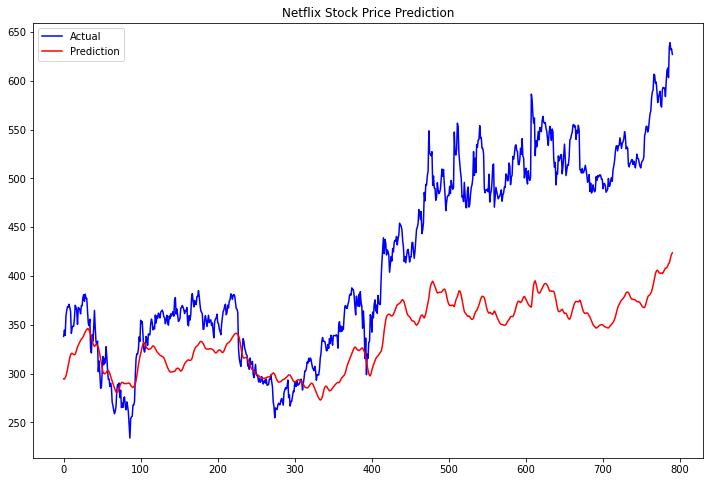

In [78]:
plt.figure(figsize=(14,8))
plt.title('Netflix Stock Price Prediction')
plt.plot(y_test_transformed, color='blue', label='Actual')
plt.plot(prediction_transformed, color='red', label='Prediction')
plt.legend()
plt.show()

# Conclusions
Here is the chart it is almost identical but not accurate, we can improve the model accurancy by using ideal configurations